In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
from pathlib import Path
sys.path.append("/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/src/")
from hmm_NB_BB_phaseswitch import *
from utils_phase_switch import *

from matplotlib import pyplot as plt
import seaborn
import scanpy as sc
import anndata
plt.rcParams.update({'font.size': 14})

# Load example data

In [2]:
# X is the count matrix of size (n_snps, 2, n_samples), where X[:,0,:] is the numerator for RDR, and X[:,1,:] is the numerator for BAF
X = np.load("/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/example/X.npy")

# lengths is the vector of chromosome lengths, to indicate the start of a new HMM sequence rather than transitioning from previous locus.
lengths = np.load("/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/example/lengths.npy")

# base_nb_mean is the normal read count matrix of size (n_snps, n_samples), which is the denominator for RDR
base_nb_mean = np.load("/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/example/base_nb_mean.npy")

# total_bb_RD is the SNP-covering read count matrix of size (n_snps, n_samples), which is the denominator of BAF
total_bb_RD = np.load("/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/example/total_bb_RD.npy")

# sorted_chr_pos encodes the genomic position of each SNP, for which the size is (n_snps, 2).
# sorted_chr_pos[:,0] is the integer chromosome, sorted_chr_pos[:,1] is the integer position in the corresponding chromosome.
sorted_chr_pos = np.load("/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/example/sorted_chr_pos.npy")


### Some visualization for RDR and BAF

/tmp/ipykernel_2899835/27112684.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/27112684.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/27112684.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], s=10, linewidth=0, ax=axes[s])


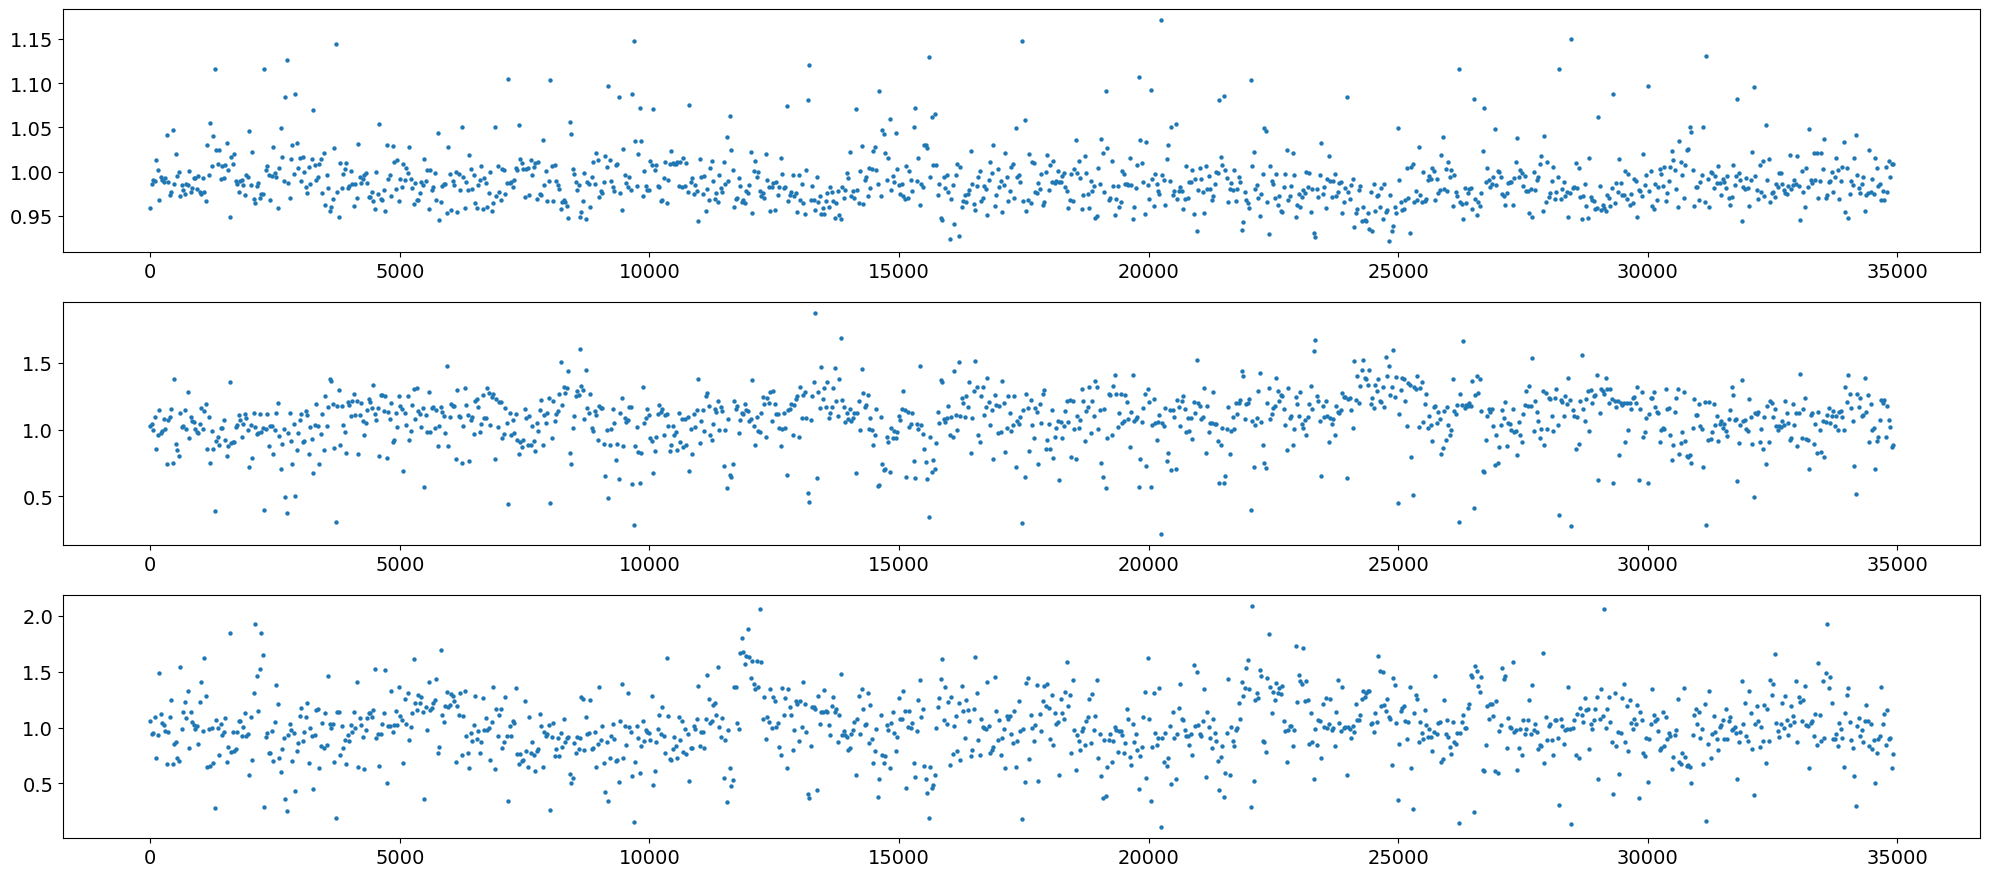

In [3]:
# RDR
n_snps = X.shape[0]
n_samples = X.shape[2]

fig, axes = plt.subplots(n_samples, 1, figsize=(20,3*n_samples), facecolor="white")
for s in range(n_samples):
    seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], s=10, linewidth=0, ax=axes[s])
fig.tight_layout()
fig.show()

/tmp/ipykernel_2899835/2723834542.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/2723834542.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/2723834542.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], s=10, linewidth=0, ax=axes[s])


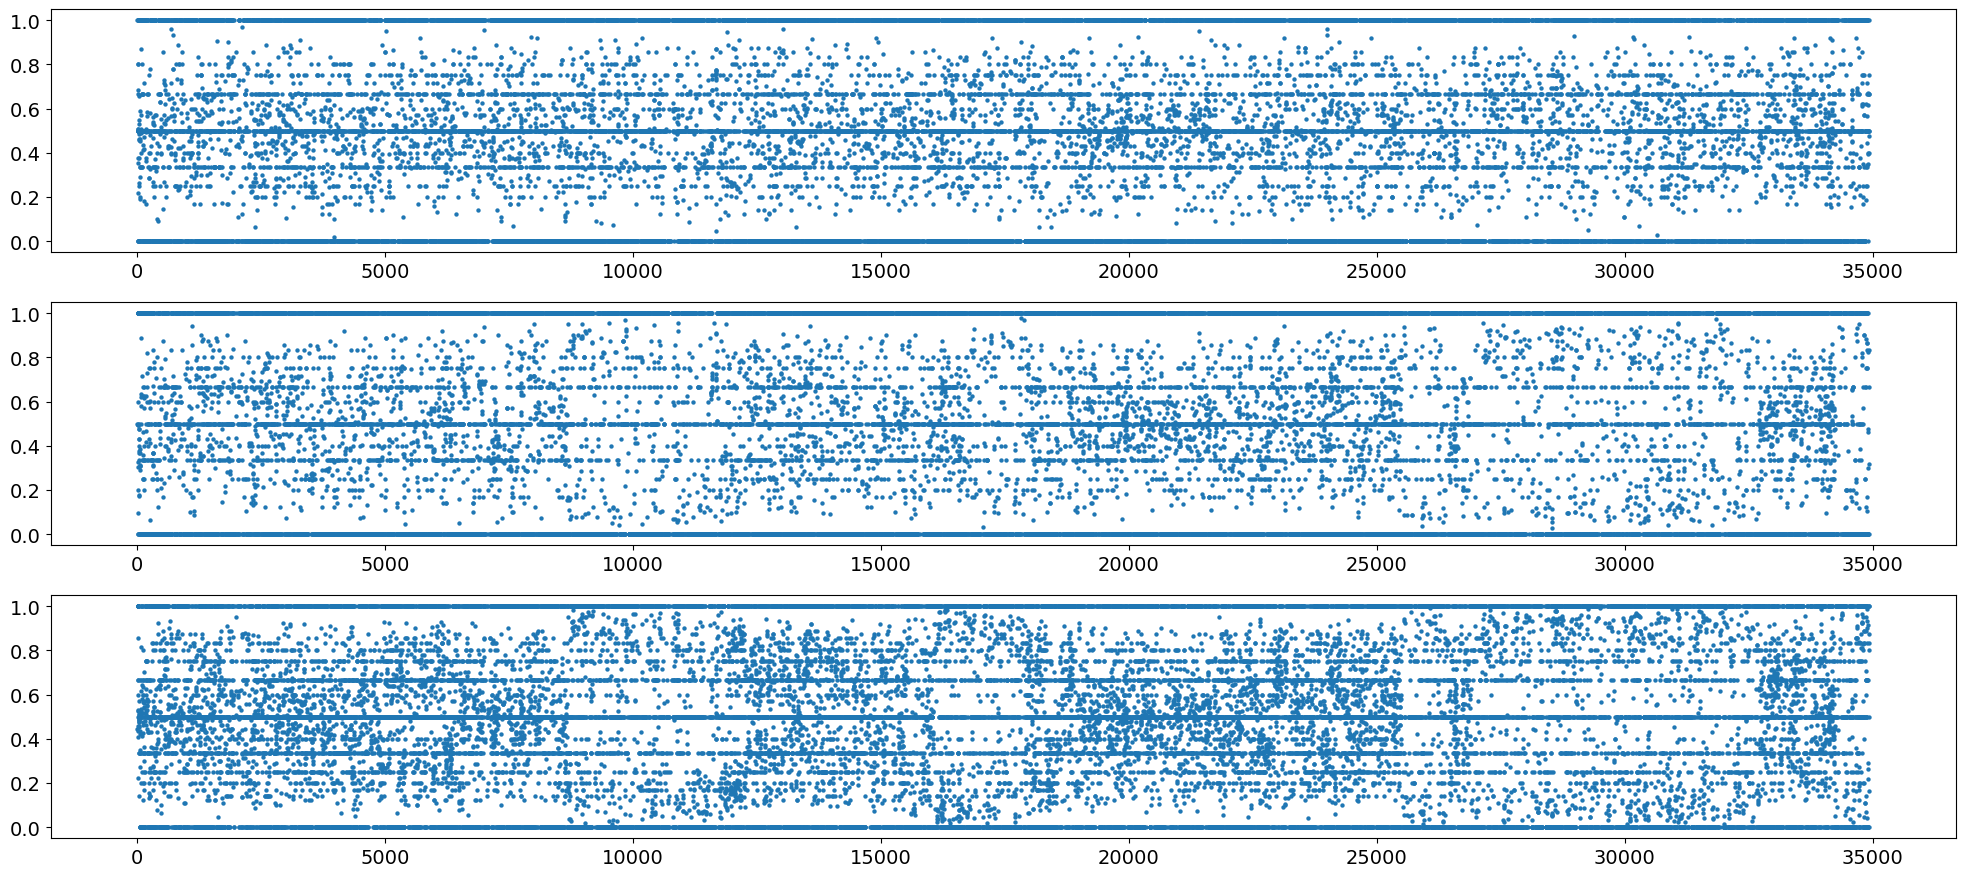

In [4]:
# BAF
n_snps = X.shape[0]
n_samples = X.shape[2]

fig, axes = plt.subplots(n_samples, 1, figsize=(20,3*n_samples), facecolor="white")
for s in range(n_samples):
    seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], s=10, linewidth=0, ax=axes[s])
fig.tight_layout()
fig.show()

# Compute phase switch probability (probability of an error in reference-based phasing)

In [5]:
position_cM = get_position_cM_table(sorted_chr_pos)
phase_switch_prob = compute_phase_switch_probability_position(position_cM, sorted_chr_pos)

# convert to log scale
log_phaseswitch = np.log(phase_switch_prob)

In [6]:
hmmmodel = hmm_sitewise(params = "smp", t=1-1e-6)
# params: s for start probability, m for RDR Negative Binomial parameters, p for BAF Beta-binomial parameters
# t: self-transition in transition probability matrix.

n_states = 5
# n_states is the number of copy number states to infer

init_log_mu = np.vstack([np.linspace(-0.1, 0.1, n_states), np.linspace(-0.1, 0.1, n_states), np.linspace(-0.1, 0.1, n_states)]).T
# init_log_mu: initialization of log of Negative binomial mean. Size (n_states, n_samples)
# I usually use GMM to initialize init_log_mu rather than specify an arbitrary number by myself.

init_p_binom = np.vstack([np.linspace(0.1, 0.5, n_states), np.linspace(0.1, 0.5, n_states), np.linspace(0.1, 0.5, n_states)]).T
# init_p_binom: initialization of Beta-binomial mean (or p). Size (n_states, n_samples)
# I usually use GMM to initialize init_log_mu rather than specify an arbitrary number by myself.

new_log_mu, new_alphas, new_p_binom, new_taus, new_log_startprob, new_log_transmat = hmmmodel.run_baum_welch_nb_bb_sitewise(X, lengths, n_states, base_nb_mean, total_bb_RD, log_phaseswitch, \
        fix_NB_dispersion=False, shared_NB_dispersion=False, fix_BB_dispersion=False, shared_BB_dispersion=False, consider_normal=False, shared_BB_dispersion_normal=True, \
        relative_rdr_weight=1.0, is_diag=False, init_log_mu=init_log_mu, init_p_binom=init_p_binom, init_alphas=None, init_taus=None, max_iter=30, tol=1e-4)
# outputs:
# new_log_mu and new_alphas: Negative binomial log mean and dispersion for RDR. Size (n_states, n_samples). Each state within each sample may have their own NB parameters
# new_p_binom and new_taus: Beta-binomial p and "dispersion" for BAF. Size (n_states, n_samples). Note that the conversion of these parameterization to wiki page Beta-binomial is BetaBin(tau * p, tau * (1-p))
# new_log_startprob: log of start probability. Size (n_states, n_states)
# new_log_transmat: log of transition probability matrix. Size (n_states, n_states)
# parameters:
# X, lengths, n_states, base_nb_mean, total_bb_RD: loaded data shown previously
# log_phaseswitch: log phase-switch probability modeled by recombination rate.



  0%|                                                                                                                                      | 0/30 [00:00<?, ?it/s]/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/src/utils_distribution_fitting.py:39: RuntimeWarning: invalid value encountered in sqrt
  nb_std = np.sqrt(nb_mean + params[-1] * nb_mean**2)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exo

0.14603508805810467 0.0 0.1333553138856849 0.030209601471991986
[[ 0.07508897 -0.48207431 -0.79085414  0.08717769  0.12700324  0.12115933]
 [-0.01539962  0.09506683 -0.00711668  0.38347596  0.18009643  0.18892503]
 [-0.00729739  0.05368367 -0.01240257  0.40854594  0.29714018  0.26640119]
 [-0.0098993   0.07213901  0.03617185  0.42719615  0.39771296  0.39921963]
 [-0.00547839  0.04514478 -0.10017807  0.5007051   0.49852043  0.49974817]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
  7%|████████▍                                                                                                                     | 2/30 [00:27<05:58, 12.80s/it]

0.024350345150776727 0.0 0.00970053235859825 0.006336563923994599
[[ 0.07826307 -0.50558108 -0.82402232  0.08655999  0.12597054  0.13340472]
 [-0.01890907  0.11964399  0.010924    0.41184374  0.18436213  0.19553549]
 [-0.00615284  0.04496448 -0.02154946  0.43535757  0.29799944  0.26830891]
 [-0.01054276  0.07688269  0.03987943  0.43177694  0.40038064  0.40220296]
 [-0.00562926  0.04307343 -0.10938214  0.5009955   0.49713642  0.49932427]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/Codes/locality-clustering-cnv/src/utils_distribution_fitting.py:26: RuntimeWarning: divide by zero encountered in true_divide
  n = mean*p/(1.0 - p)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:332: RuntimeWarning: invalid value encountered in subtract
  coeff = gamln(n+x) - gamln(x+1) - gamln(n)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:333: RuntimeWarning: invalid value encountered in multiply
  return coeff + n*log(p) + special.xlog1py(x, -p)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/li

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environ

0.0028858678352512712 0.0 0.002121783249398361 0.003382533693134297
[[ 0.07835479 -0.50576623 -0.82418326  0.08388881  0.11590004  0.13608466]
 [-0.01860254  0.12009395  0.03451983  0.40871609  0.18560936  0.20312329]
 [-0.0061014   0.04393505 -0.0247084   0.443458    0.30134044  0.27214528]
 [-0.01047639  0.07684162  0.03892029  0.43351874  0.40219238  0.40427283]
 [-0.00568863  0.0425473  -0.10823742  0.50077034  0.49568326  0.49855011]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 13%|████████████████▊                                                                                                             | 4/30 [00:45<04:32, 10.48s/it]

6.222543471382816e-05 0.0 0.0012403071543941476 0.0022122241651805117
[[ 0.07835479 -0.50566745 -0.82418326  0.08123477  0.10885365  0.13798769]
 [-0.01814837  0.11682356  0.04409463  0.40744597  0.18845422  0.20642918]
 [-0.00599713  0.04348988 -0.02675987  0.44618541  0.30340019  0.27450426]
 [-0.01047639  0.07664742  0.03816612  0.43419043  0.40315053  0.40534657]
 [-0.00574713  0.04260369 -0.10669513  0.49979398  0.49378152  0.49711887]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 17%|█████████████████████                                                                                                         | 5/30 [00:54<04:09, 10.00s/it]

0.0010483305021761716 0.0 0.0005862424128406372 0.001282385373813355
[[ 0.07835479 -0.50576621 -0.82418326  0.08073458  0.10783776  0.13817339]
 [-0.01791797  0.11404764  0.04786733  0.40747088  0.19057365  0.20932026]
 [-0.00595094  0.04306235 -0.02800489  0.44721636  0.30455956  0.27567982]
 [-0.01047703  0.07668739  0.03806917  0.43443642  0.40349991  0.40575756]
 [-0.00574713  0.04259691 -0.10664236  0.49747324  0.49078157  0.49431321]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 20%|█████████████████████████▏                                                                                                    | 6/30 [01:04<03:53,  9.71s/it]

8.416651501929051e-05 0.0 0.000484666196351809 0.0014650318846085725
[[ 0.07835479 -0.50576621 -0.82418326  0.08067175  0.10776404  0.13814355]
 [-0.01783472  0.1119536   0.05099219  0.40789218  0.19244135  0.21198456]
 [-0.00580528  0.04267259 -0.02934807  0.44768513  0.30536216  0.27630444]
 [-0.01047703  0.07668739  0.03806917  0.4345222   0.4036169   0.40590577]
 [-0.00574713  0.04261305 -0.10656926  0.49273138  0.48595374  0.48927409]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 23%|█████████████████████████████▍                                                                                                | 7/30 [01:13<03:38,  9.50s/it]

0.00018778419165406678 0.0 0.00023413927291309546 0.0018642393794807365
[[ 0.07835479 -0.50576621 -0.82418326  0.08067176  0.10781738  0.1381435 ]
 [-0.01773827  0.11038062  0.051393    0.40870082  0.1946705   0.2138697 ]
 [-0.00575204  0.04238368 -0.03008237  0.44791768  0.30593821  0.2767325 ]
 [-0.01047703  0.07667694  0.03813086  0.43454702  0.4036451   0.40594347]
 [-0.00574713  0.04273126 -0.10639418  0.48500891  0.47933733  0.48195309]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 27%|█████████████████████████████████▌                                                                                            | 8/30 [01:22<03:25,  9.36s/it]

0.0004297575543388943 0.0 0.00043988091583922225 0.0020880923170038005
[[ 0.07835479 -0.50576621 -0.82418326  0.0807352   0.10801143  0.13808954]
 [-0.01758497  0.10832923  0.04837165  0.41032125  0.19846279  0.21526776]
 [-0.00570935  0.04191013 -0.03045524  0.44805398  0.30653257  0.27725147]
 [-0.01047703  0.07670021  0.03829362  0.43453724  0.4036246   0.4059111 ]
 [-0.00574713  0.04267993 -0.10663987  0.4761289   0.47271977  0.47456376]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 30%|█████████████████████████████████████▊                                                                                        | 9/30 [01:31<03:14,  9.27s/it]

0.0008262347198868258 0.0 0.0010077246840319532 0.0019932357739350036
[[ 0.07835479 -0.50576621 -0.82418326  0.08086144  0.1082804   0.1379922 ]
 [-0.01731793  0.10530485  0.04263586  0.41291743  0.20420868  0.21658465]
 [-0.00551309  0.04126302 -0.03078336  0.44817313  0.30741421  0.27809545]
 [-0.01060595  0.07696328  0.03918597  0.43448562  0.40350888  0.40577173]
 [-0.00534455  0.04168757 -0.10887779  0.4688393   0.46764154  0.46933605]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 33%|█████████████████████████████████████████▋                                                                                   | 10/30 [01:40<03:05,  9.27s/it]

0.0014488390800076203 0.0 0.0024425826030431445 0.0014769963532207313
[[ 0.07835479 -0.50576621 -0.82418326  0.08096382  0.10866108  0.13788441]
 [-0.01715705  0.10403951  0.03905395  0.41468466  0.20737103  0.21738265]
 [-0.00540034  0.04082758 -0.03074737  0.44819934  0.30805484  0.2787246 ]
 [-0.01106485  0.07925372  0.04303121  0.43436041  0.40312424  0.40534194]
 [-0.00309805  0.031055   -0.12045058  0.4636766   0.46288424  0.46565516]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 37%|█████████████████████████████████████████████▊                                                                               | 11/30 [01:49<02:55,  9.23s/it]

0.0039371830486004305 0.0 0.0022735970368972153 0.0011598355571615575
[[ 7.83547878e-02 -5.05766213e-01 -8.24183257e-01  8.13828662e-02
   1.09922091e-01  1.37393606e-01]
 [-1.71570534e-02  1.03877795e-01  3.77262645e-02  4.15504208e-01
   2.08344172e-01  2.17779531e-01]
 [-5.37488695e-03  4.07723583e-02 -3.06237411e-02  4.48153997e-01
   3.08297419e-01  2.78983057e-01]
 [-1.18752596e-02  8.28919105e-02  4.84414524e-02  4.33835553e-01
   4.02893836e-01  4.04081719e-01]
 [-4.62197172e-04  1.89827084e-02 -1.28293831e-01  4.61105402e-01
   4.56322584e-01  4.64312783e-01]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 40%|██████████████████████████████████████████████████                                                                           | 12/30 [01:58<02:45,  9.19s/it]

0.013718897601491104 0.0 0.0005771115784403695 0.0011317891629907503
[[ 7.83547878e-02 -5.05766213e-01 -8.24183257e-01  8.23961763e-02
   1.12820427e-01  1.36303832e-01]
 [-1.71570534e-02  1.03886756e-01  3.71213379e-02  4.15937917e-01
   2.08739384e-01  2.18063356e-01]
 [-5.37488695e-03  4.06377750e-02 -3.06155476e-02  4.48108877e-01
   3.08399813e-01  2.79085706e-01]
 [-1.22054460e-02  8.39669653e-02  5.20741594e-02  4.33481761e-01
   4.02744639e-01  4.02836877e-01]
 [-1.46437763e-04  2.05966819e-02 -1.27361503e-01  4.58994856e-01
   4.50568737e-01  4.63312496e-01]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 43%|██████████████████████████████████████████████████████▏                                                                      | 13/30 [02:07<02:33,  9.03s/it]

0.002050920604848125 0.0 0.0006567255732537242 0.0012585163841646652
[[ 7.83547878e-02 -5.05766213e-01 -8.24183257e-01  8.37581274e-02
   1.17585526e-01  1.34970036e-01]
 [-1.70847855e-02  1.03905528e-01  3.66138633e-02  4.16289266e-01
   2.09054826e-01  2.18374666e-01]
 [-5.37488695e-03  4.06377750e-02 -3.05372171e-02  4.48069489e-01
   3.08469595e-01  2.79125863e-01]
 [-1.27291538e-02  8.60441228e-02  5.67374540e-02  4.32986284e-01
   4.02655038e-01  4.01004475e-01]
 [ 2.78512594e-04  1.92248884e-02 -1.27474638e-01  4.57467501e-01
   4.44718079e-01  4.63806474e-01]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 47%|██████████████████████████████████████████████████████████▎                                                                  | 14/30 [02:16<02:23,  8.98s/it]

0.00026288010723196366 0.0 0.0020673895579765866 0.0014962937014200927
[[ 0.07835479 -0.50576621 -0.82418326  0.0849859   0.12251287  0.13362561]
 [-0.01708479  0.10383872  0.03592924  0.41669039  0.20943825  0.21876526]
 [-0.00537489  0.0405717  -0.0304481   0.44802774  0.30854003  0.27914978]
 [-0.01385554  0.09266611  0.06511827  0.4322767   0.40287359  0.39800903]
 [ 0.00155596  0.00754563 -0.12849296  0.45589143  0.43744975  0.46467212]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 50%|██████████████████████████████████████████████████████████████▌                                                              | 15/30 [02:25<02:13,  8.91s/it]

0.00024326355821394362 0.0 0.0019325775266763828 0.0011146850424252285
[[ 0.07835479 -0.50576621 -0.82418326  0.0857396   0.12516887  0.13260123]
 [-0.0170948   0.10390645  0.03498977  0.41731248  0.21005699  0.2193996 ]
 [-0.00537489  0.04044959 -0.03030366  0.44797112  0.30865522  0.27918096]
 [-0.01483782  0.09724172  0.06804918  0.43171299  0.40248263  0.3947863 ]
 [ 0.00195145  0.00593594 -0.11128204  0.45396999  0.43371953  0.46429314]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 53%|██████████████████████████████████████████████████████████████████▋                                                          | 16/30 [02:33<02:04,  8.89s/it]

0.0004258074275779539 0.0 0.003162564738862926 0.0020843909223035952
[[ 7.83547878e-02 -5.05766213e-01 -8.24183257e-01  8.53964191e-02
   1.24316765e-01  1.32486598e-01]
 [-1.70138295e-02  1.03981991e-01  3.16991568e-02  4.19326975e-01
   2.12198186e-01  2.21488679e-01]
 [-5.33150619e-03  4.00458686e-02 -2.98926890e-02  4.47786935e-01
   3.09083345e-01  2.79232523e-01]
 [-1.57191744e-02  1.00332998e-01  8.54229417e-02  4.31412385e-01
   4.03692109e-01  3.89422771e-01]
 [-4.08241796e-05  2.01610683e-02 -1.05712560e-01  4.50370428e-01
   4.25089665e-01  4.60348869e-01]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 17/30 [02:43<01:57,  9.04s/it]

0.029426807943880105 0.0 0.004515033506178248 0.004301961558808688
[[ 0.07835479 -0.50576621 -0.82418326  0.08005914  0.10793739  0.13556593]
 [-0.01687759  0.1038727   0.02535557  0.42301524  0.21603068  0.22524718]
 [-0.00520447  0.03899525 -0.02916365  0.44735307  0.30993754  0.27931698]
 [-0.01684116  0.11148055  0.10092222  0.43076524  0.40567543  0.37884668]
 [-0.00197794  0.02463737 -0.08066511  0.44682335  0.4173769   0.45773359]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 60%|███████████████████████████████████████████████████████████████████████████                                                  | 18/30 [02:52<01:48,  9.04s/it]

0.013025624061572838 0.0 0.0019104818237019457 0.002145590044398481
[[ 0.07835479 -0.50576621 -0.82418326  0.07768883  0.10344075  0.13568388]
 [-0.01626404  0.10013531  0.01619375  0.42730764  0.21909907  0.22931206]
 [-0.00513331  0.03837319 -0.0281565   0.44655201  0.31084599  0.27933017]
 [-0.01705686  0.11270752  0.10621169  0.43039049  0.40710519  0.37370482]
 [-0.00249055  0.02771553 -0.07754391  0.44616242  0.41374416  0.45692306]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 19/30 [03:01<01:39,  9.02s/it]

0.01762294394819161 0.0 0.0018929654770404461 0.0015285534371771
[[ 0.07835479 -0.50576621 -0.82418326  0.0771376   0.10273679  0.13530963]
 [-0.01543496  0.09387596  0.00153689  0.43133259  0.22372159  0.23581923]
 [-0.0047599   0.03705663 -0.02574325  0.44535608  0.31233151  0.27909287]
 [-0.01712068  0.11265153  0.10660095  0.43026079  0.40713862  0.3719391 ]
 [-0.00262405  0.02858994 -0.07651492  0.44609418  0.41277609  0.45666277]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 20/30 [03:10<01:30,  9.01s/it]

0.020759795344824344 0.0 0.0007489546007773536 0.001115678477343283
[[ 0.07835479 -0.50576621 -0.82418326  0.0769709   0.10257582  0.1351701 ]
 [-0.01516402  0.09331917 -0.00336012  0.43445731  0.22813716  0.2401071 ]
 [-0.00438077  0.03394667 -0.02526291  0.44427838  0.31435855  0.2791377 ]
 [-0.01712068  0.11256532  0.10675277  0.43018478  0.4070511   0.37123166]
 [-0.00270851  0.02916151 -0.07586885  0.44609169  0.41246745  0.45655461]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 21/30 [03:19<01:20,  8.93s/it]

0.028463927724624267 0.0 0.0010151732810954077 0.0011214430779738298
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10251435  0.1351701 ]
 [-0.01522729  0.09750374 -0.00376176  0.4368772   0.23397049  0.24377359]
 [-0.00361226  0.0265108  -0.02694591  0.44343496  0.31730066  0.27955976]
 [-0.01712068  0.1125249   0.10683633  0.43014007  0.40697977  0.37092408]
 [-0.00270851  0.02943461 -0.07557518  0.44609693  0.41237319  0.45649011]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 22/30 [03:27<01:11,  8.89s/it]

0.016352424648721532 0.0 0.0007327066566252574 0.0007879257606359158
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10251435  0.1351701 ]
 [-0.01528677  0.09956102 -0.0023197   0.43889323  0.23784798  0.24623005]
 [-0.00308594  0.02173453 -0.02887778  0.44270346  0.31944714  0.27987453]
 [-0.01712068  0.11244363  0.10686726  0.43011637  0.4069364   0.37078681]
 [-0.00270851  0.02945102 -0.07550647  0.44609875  0.41234414  0.45644917]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 23/30 [03:36<01:02,  8.86s/it]

0.0038305142163105764 0.0 0.00022044913812999892 0.00048385044620290565
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10252049  0.13514879]
 [-0.01528677  0.09948505 -0.00146061  0.44069494  0.23987936  0.24763928]
 [-0.00287192  0.02074576 -0.02976573  0.44203313  0.32050385  0.28000647]
 [-0.01712068  0.11247769  0.1069548   0.43010403  0.40691338  0.37072569]
 [-0.00270851  0.02951756 -0.07541367  0.44609889  0.41233551  0.45642542]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 24/30 [03:45<00:52,  8.83s/it]

0.0010467501244003196 0.0 7.537272909890272e-05 0.0003136261447277707
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10252174  0.13514879]
 [-0.01529619  0.09931673 -0.00133328  0.44203255  0.24129556  0.24850909]
 [-0.00278931  0.02033956 -0.03001404  0.44152431  0.32097048  0.28005301]
 [-0.01712068  0.11250454  0.1069548   0.43009851  0.40690231  0.37069833]
 [-0.00270851  0.02957911 -0.07541367  0.44609873  0.41233447  0.45641304]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 25/30 [03:54<00:43,  8.78s/it]

0.0004295325186153331 0.0 3.005756426590242e-05 0.00020106225941390703
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10252166  0.13514879]
 [-0.01529619  0.09931673 -0.00129759  0.44291403  0.24226675  0.24908882]
 [-0.0028002   0.02007729 -0.03014489  0.44119136  0.32118156  0.28004258]
 [-0.01712068  0.11250454  0.1069548   0.43009619  0.40689724  0.37068604]
 [-0.00270851  0.02957911 -0.07542483  0.44609915  0.41233613  0.45640579]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 26/30 [04:02<00:35,  8.77s/it]

0.0002027156375005168 0.0 2.6714030191002512e-05 0.00013031429542999148
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10252166  0.13514879]
 [-0.01536793  0.09922762 -0.00137139  0.44346104  0.24291503  0.24949064]
 [-0.0028002   0.0199199  -0.03014507  0.44099036  0.32128864  0.28000829]
 [-0.01712068  0.11250454  0.1069548   0.43009526  0.40689466  0.37068035]
 [-0.00270851  0.02957911 -0.07541634  0.44609953  0.41233793  0.45640192]]


/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names 

/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
/u/congma/ragr-data/users/congma/environments/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 26/30 [04:11<00:38,  9.67s/it]

6.142093054759546e-05 0.0 2.7946736183853712e-05 8.264754626999827e-05
[[ 0.07835479 -0.50576621 -0.82418326  0.07692565  0.10252166  0.13514879]
 [-0.01531221  0.09932163 -0.00137139  0.44379417  0.24333919  0.24976011]
 [-0.0026896   0.01981733 -0.03017051  0.44087337  0.32134143  0.27997187]
 [-0.01712068  0.11250454  0.1069548   0.43009522  0.40689379  0.37067772]
 [-0.00270851  0.02957911 -0.07538547  0.44609943  0.41233861  0.45639949]]


In [7]:
# forward-backward posterior distribution
log_gamma = posterior_nb_bb_sitewise(X, lengths, base_nb_mean, new_log_mu, new_alphas, total_bb_RD, new_p_binom, new_taus, new_log_startprob, new_log_transmat, log_phaseswitch)
# log_gamma: posterior probability of each SNP belong to each phase and each state, size (2*n_states, n_snps). It aggregates all samples for shared states and concurrent breakpoints.
# first n_states rows indicate first phase, last n_states rows indicates the other phase.

pred_cnv = np.argmax(log_gamma, axis=0) % n_states
pred_phase = (np.argmax(log_gamma, axis=0) < n_states)

/tmp/ipykernel_2899835/185141430.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/185141430.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/185141430.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])


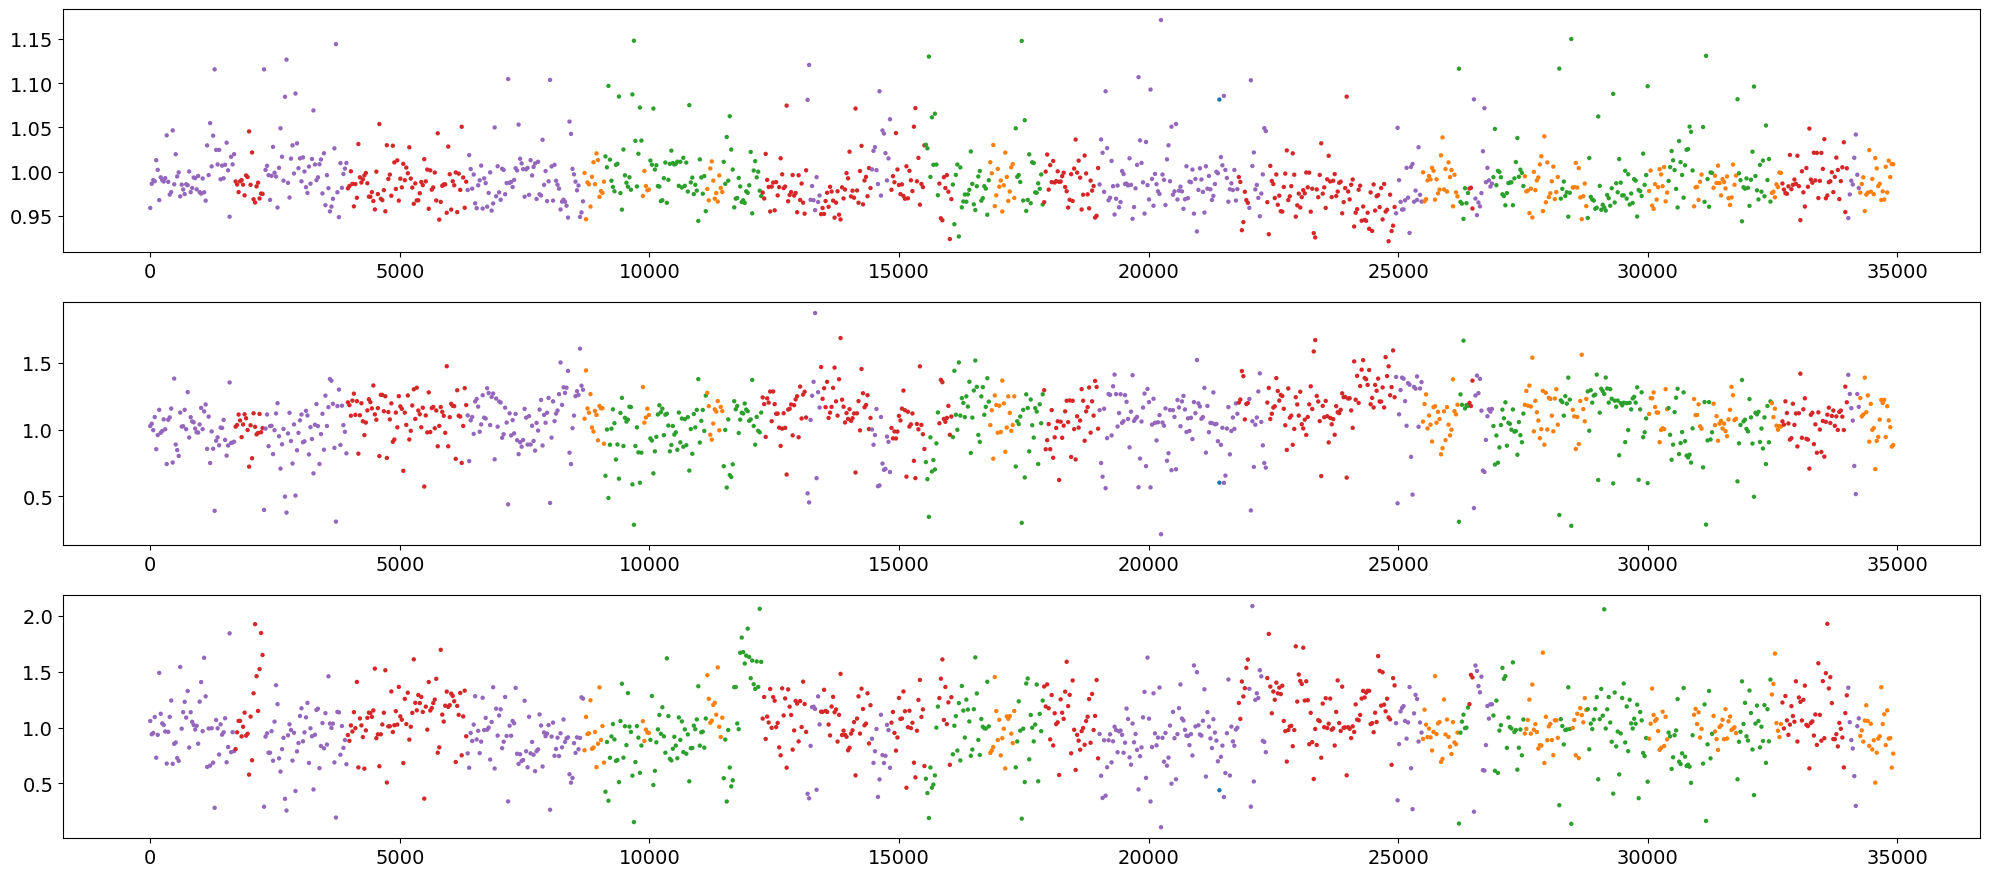

In [8]:
# RDR
n_snps = X.shape[0]
n_samples = X.shape[2]

fig, axes = plt.subplots(n_samples, 1, figsize=(20,3*n_samples), facecolor="white")
for s in range(n_samples):
    seaborn.scatterplot(x=np.arange(n_snps), y=X[:,0,s] / base_nb_mean[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])
fig.tight_layout()
fig.show()

/tmp/ipykernel_2899835/3127306585.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/3127306585.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/3127306585.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])


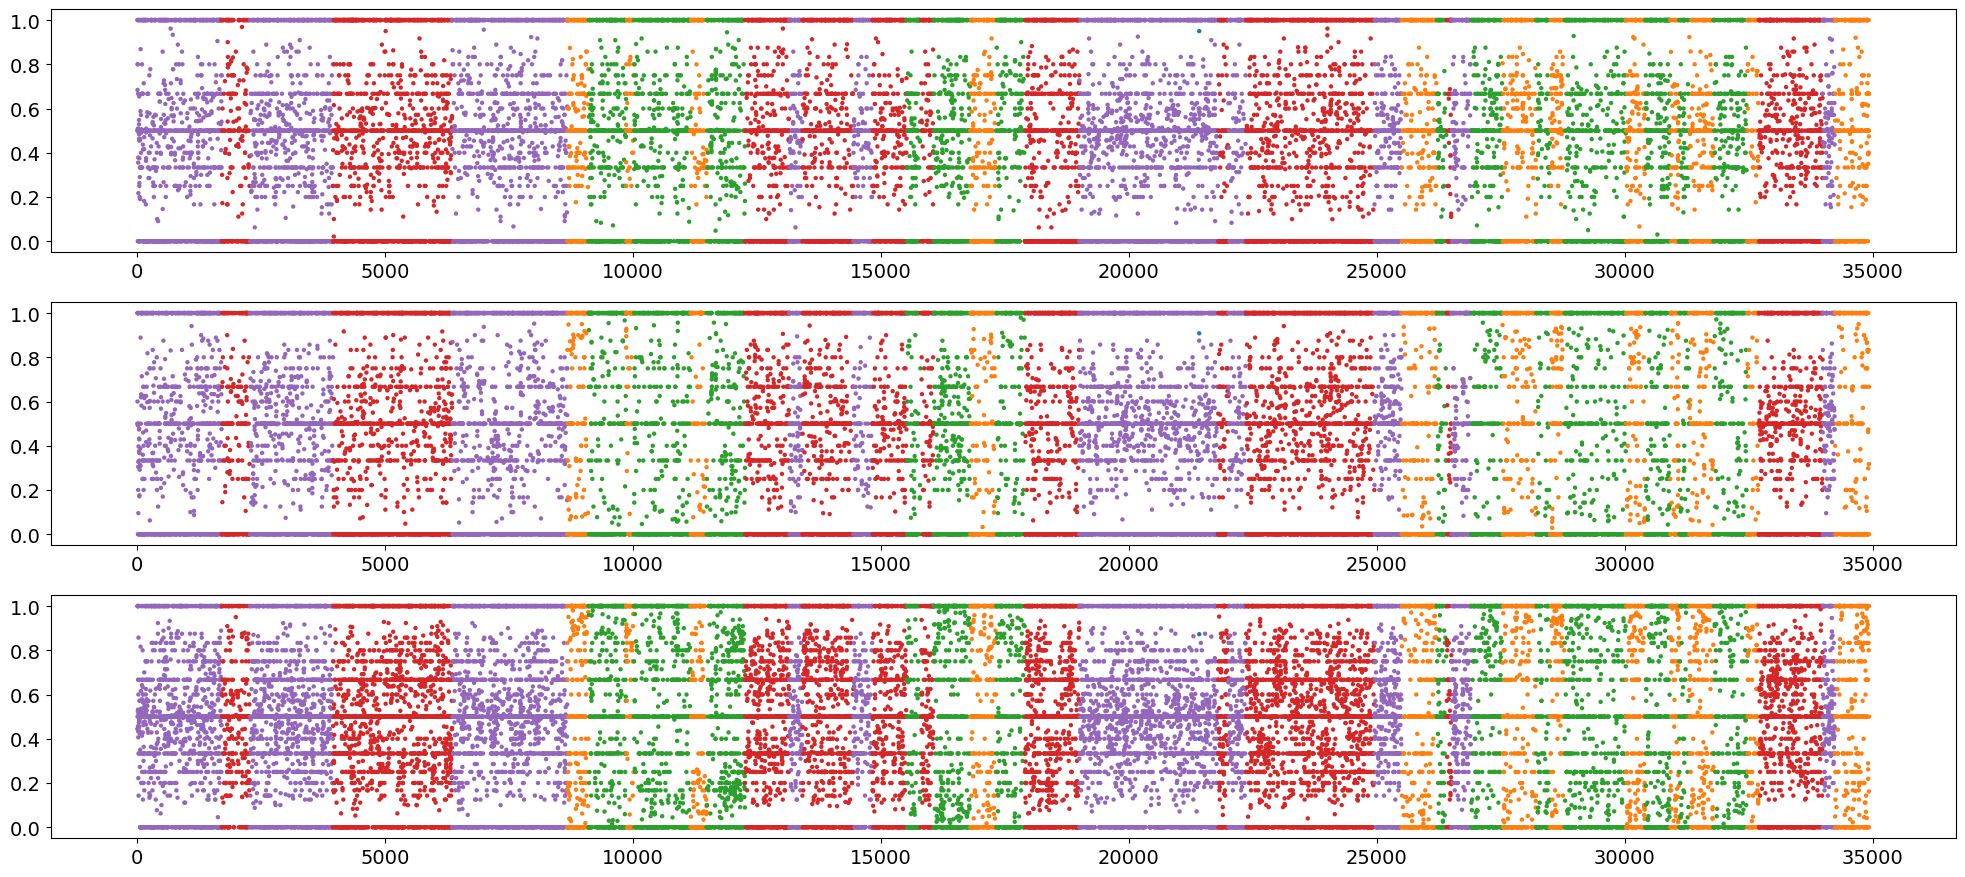

In [9]:
# BAF colored by copy number state
n_snps = X.shape[0]
n_samples = X.shape[2]

fig, axes = plt.subplots(n_samples, 1, figsize=(20,3*n_samples), facecolor="white")
for s in range(n_samples):
    seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_cnv, palette="tab10", legend=False, s=10, linewidth=0, ax=axes[s])
fig.tight_layout()
fig.show()

/tmp/ipykernel_2899835/1788285819.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_phase, legend=False, s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/1788285819.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_phase, legend=False, s=10, linewidth=0, ax=axes[s])
/tmp/ipykernel_2899835/1788285819.py:7: RuntimeWarning: invalid value encountered in true_divide
  seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_phase, legend=False, s=10, linewidth=0, ax=axes[s])


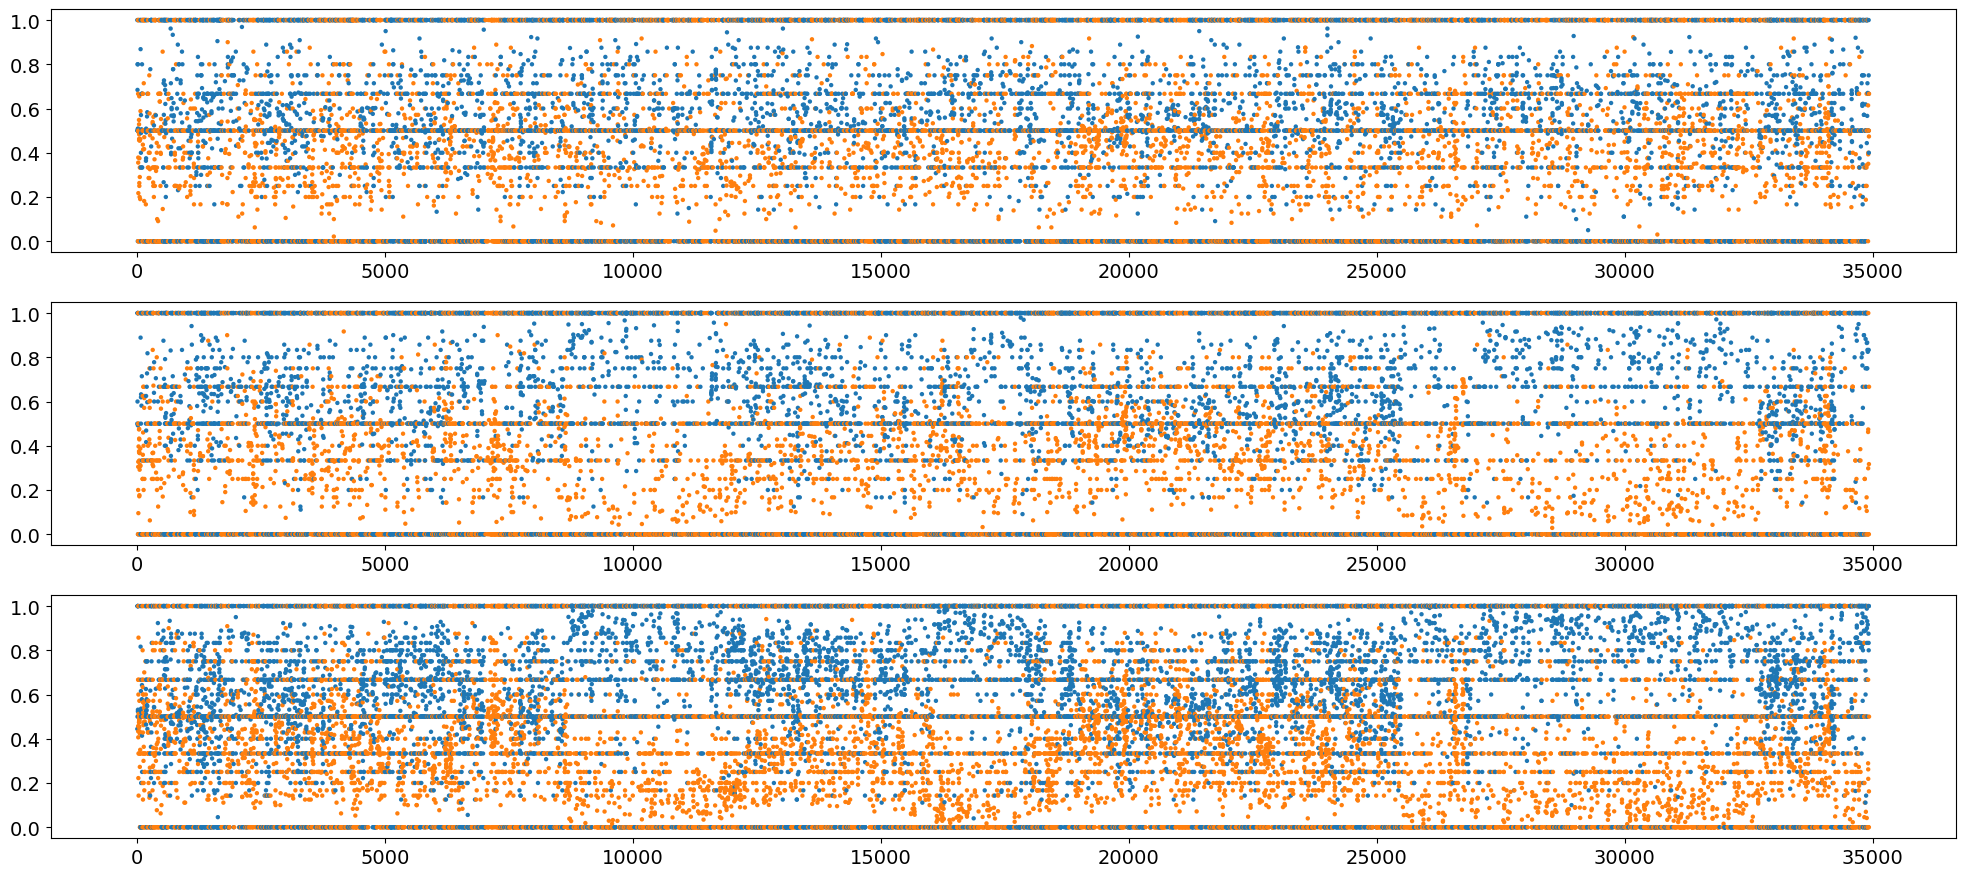

In [10]:
# BAF colored by phase
n_snps = X.shape[0]
n_samples = X.shape[2]

fig, axes = plt.subplots(n_samples, 1, figsize=(20,3*n_samples), facecolor="white")
for s in range(n_samples):
    seaborn.scatterplot(x=np.arange(n_snps), y=X[:,1,s] / total_bb_RD[:,s], hue=pred_phase, legend=False, s=10, linewidth=0, ax=axes[s])
fig.tight_layout()
fig.show()